In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import softmax

from d2l import torch as d2l

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

/home/nastya/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
!pip install d2l

Defaulting to user installation because normal site-packages is not writeable


# Data preparation

In [10]:
class TokenEmbedding:
    """Token Embedding."""

    def __init__(self, embedding_name):
        """Defined in :numref:`sec_synonyms`"""
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        with open('vec.txt', 'r', encoding="utf-8") as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, d2l.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[d2l.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [11]:
def data_preparation(is_train=False):
    if is_train:
        df = pd.read_csv("drugLibTrain_raw.tsv", sep="\t", header=0)
    else:
        df = pd.read_csv("drugLibTest_raw.tsv", sep="\t", header=0)
    df.fillna('', inplace=True)

    rating_classes = range(1, 11)
    effectiveness_classes = ['Ineffective', 'Marginally Effective', 'Moderately Effective', 'Considerably Effective',
                             'Highly Effective']
    side_effects_classes = ['No Side Effects', 'Mild Side Effects', 'Moderate Side Effects', 'Severe Side Effects',
                            'Extremely Severe Side Effects']

    df["rating"] = df["rating"].replace(rating_classes, [0, 0, 0, 1, 1, 1, 1, 2, 2, 2])
    df["effectiveness"] = df["effectiveness"].replace(effectiveness_classes, [0, 1, 1, 2, 2])
    df["sideEffects"] = df["sideEffects"].replace(side_effects_classes, [0, 1, 1, 2, 2])
    return df

In [12]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, model=nn.LSTM, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = model(embed_size,
                              num_hiddens,
                              num_layers=num_layers,
                              bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 3)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [13]:
def data_tasks(df, task):
    if task == "overall_rating":
        data = df["commentsReview"]
        labels = df["rating"]
    elif task == "effectiveness":
        data = df["benefitsReview"]
        labels = df["effectiveness"]
    elif task == "side_effects":
        data = df["sideEffectsReview"]
        labels = df["sideEffects"]
    return data, labels

In [14]:
def predict(model, dataloader):
    y_pred = []
    y_true = []
    confidence = []
    with torch.no_grad():
        model.eval()
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            y_true.append(y.numpy())
            y_pred_t = pred.argmax(1).cpu().numpy()
            y_pred.append(y_pred_t)
            confidence.append(softmax(pred).cpu().numpy())
    y_pred = np.concatenate([i.squeeze() for i in y_pred])
    y_true = np.concatenate([i.squeeze() for i in y_true])
    confidence = np.concatenate([i.squeeze() for i in confidence])

    return y_pred, y_true, confidence


def metrics(y_pred, y_true, confidence):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    f_1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, confidence, multi_class='ovr')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f"accuracy: {accuracy}\nbalanced_accuracy: {balanced_accuracy}\nf_1: {f_1}\nroc_auc: {roc_auc}\nprecision: {precision}\nrecall: {recall}")

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

In [16]:
glove_embedding = TokenEmbedding('glove.6b.100d')

In [17]:
train_data = data_preparation(is_train=True)
test_data = data_preparation()

# Overall

In [18]:
num_steps = 500
batch_size = 64

overall_train = data_tasks(train_data, "overall_rating")
overall_test = data_tasks(test_data, "overall_rating")

train_tokens = d2l.tokenize(overall_train[0], token='word')
test_tokens = d2l.tokenize(overall_test[0], token='word')

vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

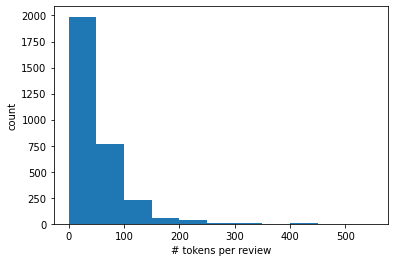

In [19]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 600, 50))
plt.show()

In [20]:
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])

test_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])


train_iter = d2l.load_array((train_features, torch.tensor(overall_train[1])),
                            batch_size)

test_iter = d2l.load_array((test_features, torch.tensor(overall_test[1])),
                           batch_size,
                           is_train=False)

## RNN

In [21]:
embed_size, num_hiddens, num_layers = 100, 100, 2

rnn_overall_rating = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.RNN)
rnn_overall_rating.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
rnn_overall_rating.embedding.weight.data.copy_(embeds)
rnn_overall_rating.embedding.weight.requires_grad = False

In [22]:
lr, num_epochs = 0.01, 5
optimizer = Adam(rnn_overall_rating.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 1.028, train acc 0.530, test acc 0.529
42.6 examples/sec on [device(type='cpu')]


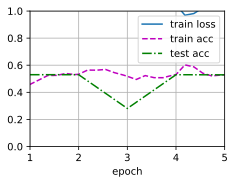

In [23]:
d2l.train_ch13(rnn_overall_rating, train_iter, test_iter, loss, optimizer, num_epochs)

In [24]:
y_pred, y_true, confidence = predict(rnn_overall_rating, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.528957528957529
balanced_accuracy: 0.33272616879174255
f_1: 0.23063973063973062
roc_auc: 0.5150745668711031
precision: 0.17648953301127213
recall: 0.33272616879174255


/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## GRU

In [25]:
embed_size, num_hiddens, num_layers = 100, 100, 2

gru_overall_rating = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.GRU)
gru_overall_rating.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
gru_overall_rating.embedding.weight.data.copy_(embeds)
gru_overall_rating.embedding.weight.requires_grad = False

In [26]:
optimizer = Adam(gru_overall_rating.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.810, train acc 0.638, test acc 0.487
8.4 examples/sec on [device(type='cpu')]


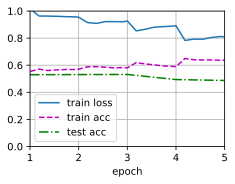

In [27]:
d2l.train_ch13(gru_overall_rating, train_iter, test_iter, loss, optimizer, num_epochs)

In [28]:
y_pred, y_true, confidence = predict(gru_overall_rating, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.4874517374517375
balanced_accuracy: 0.38092371481822634
f_1: 0.37439478797276965
roc_auc: 0.5859058825193612
precision: 0.39899678627895785
recall: 0.38092371481822634


## LSTM

In [29]:
embed_size, num_hiddens, num_layers = 100, 100, 2

lstm_overall_rating = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.LSTM)
lstm_overall_rating.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
lstm_overall_rating.embedding.weight.data.copy_(embeds)
lstm_overall_rating.embedding.weight.requires_grad = False

In [30]:
optimizer = Adam(lstm_overall_rating.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.889, train acc 0.599, test acc 0.532
4.9 examples/sec on [device(type='cpu')]


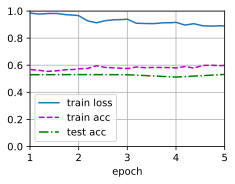

In [31]:
d2l.train_ch13(lstm_overall_rating, train_iter, test_iter, loss, optimizer, num_epochs)

In [32]:
y_pred, y_true, confidence = predict(lstm_overall_rating, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.5318532818532818
balanced_accuracy: 0.3687194843490666
f_1: 0.31800536016611725
roc_auc: 0.5941751392746862
precision: 0.43014494972694334
recall: 0.3687194843490666


# Effectiveness

In [33]:
num_steps = 300
batch_size = 64

effectiveness_train = data_tasks(train_data, "effectiveness")
effectiveness_test = data_tasks(test_data, "effectiveness")

train_tokens = d2l.tokenize(effectiveness_train[0], token='word')
test_tokens = d2l.tokenize(effectiveness_test[0], token='word')

vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

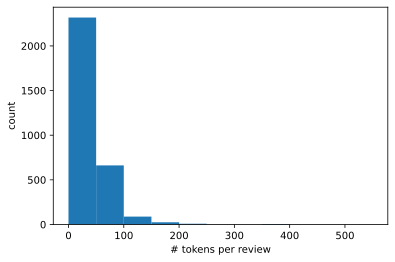

In [34]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 600, 50))
plt.show()

In [35]:
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])

test_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])


train_iter = d2l.load_array((train_features, torch.tensor(effectiveness_train[1])),
                            batch_size)

test_iter = d2l.load_array((test_features, torch.tensor(effectiveness_test[1])),
                           batch_size,
                           is_train=False)

## RNN

In [36]:
embed_size, num_hiddens, num_layers = 100, 100, 2

rnn_effectiveness = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.RNN)
rnn_effectiveness.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
rnn_effectiveness.embedding.weight.data.copy_(embeds)
rnn_effectiveness.embedding.weight.requires_grad = False

In [37]:
lr, num_epochs = 0.01, 5
optimizer = Adam(rnn_effectiveness.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.755, train acc 0.725, test acc 0.702
64.6 examples/sec on [device(type='cpu')]


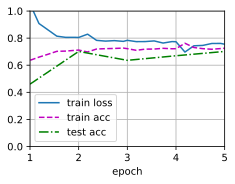

In [38]:
d2l.train_ch13(rnn_effectiveness, train_iter, test_iter, loss, optimizer, num_epochs)

In [39]:
y_pred, y_true, confidence = predict(rnn_effectiveness, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.7017374517374517
balanced_accuracy: 0.36492901683524465
f_1: 0.33329764791082844
roc_auc: 0.6073927791120093
precision: 0.5303457754629629
recall: 0.36492901683524465


## GRU

In [40]:
embed_size, num_hiddens, num_layers = 100, 100, 2

gru_effectiveness = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.GRU)
gru_effectiveness.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
gru_effectiveness.embedding.weight.data.copy_(embeds)
gru_effectiveness.embedding.weight.requires_grad = False

In [41]:
lr, num_epochs = 0.01, 5
optimizer = Adam(gru_effectiveness.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.452, train acc 0.816, test acc 0.730
14.0 examples/sec on [device(type='cpu')]


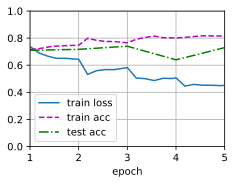

In [42]:
d2l.train_ch13(gru_effectiveness, train_iter, test_iter, loss, optimizer, num_epochs)

In [43]:
y_pred, y_true, confidence = predict(gru_effectiveness, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.7297297297297297
balanced_accuracy: 0.4950891778833797
f_1: 0.5184289771362264
roc_auc: 0.749154034674885
precision: 0.6561423888988841
recall: 0.4950891778833797


## LSTM

In [44]:
embed_size, num_hiddens, num_layers = 100, 100, 2

lstm_effectiveness = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.LSTM)
lstm_effectiveness.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
lstm_effectiveness.embedding.weight.data.copy_(embeds)
lstm_effectiveness.embedding.weight.requires_grad = False

In [45]:
lr, num_epochs = 0.01, 5
optimizer = Adam(lstm_effectiveness.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.584, train acc 0.760, test acc 0.713
14.0 examples/sec on [device(type='cpu')]


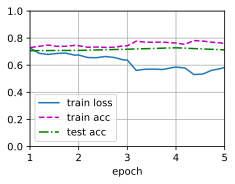

In [46]:
d2l.train_ch13(lstm_effectiveness, train_iter, test_iter, loss, optimizer, num_epochs)

In [47]:
y_pred, y_true, confidence = predict(lstm_effectiveness, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.7133204633204633
balanced_accuracy: 0.43474152208916567
f_1: 0.4313219086792528
roc_auc: 0.6859445296006413
precision: 0.628131706472828
recall: 0.43474152208916567


# Side effects

In [48]:
num_steps = 300
batch_size = 64

side_effects_train = data_tasks(train_data, "side_effects")
side_effects_test = data_tasks(test_data, "side_effects")

train_tokens = d2l.tokenize(side_effects_train[0], token='word')
test_tokens = d2l.tokenize(side_effects_test[0], token='word')

vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

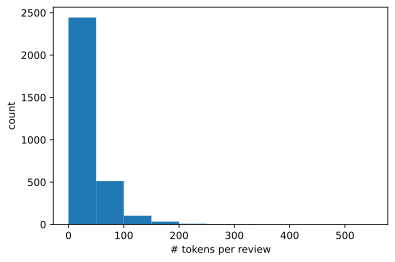

In [49]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 600, 50))
plt.show()

In [50]:
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])

test_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])


train_iter = d2l.load_array((train_features, torch.tensor(side_effects_train[1])),
                            batch_size)

test_iter = d2l.load_array((test_features, torch.tensor(side_effects_test[1])),
                           batch_size,
                           is_train=False)

## RNN

In [51]:
embed_size, num_hiddens, num_layers = 100, 100, 2

rnn_side_effects = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.RNN)
rnn_side_effects.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
rnn_side_effects.embedding.weight.data.copy_(embeds)
rnn_side_effects.embedding.weight.requires_grad = False

In [52]:
lr, num_epochs = 0.01, 5
optimizer = Adam(rnn_side_effects.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.853, train acc 0.651, test acc 0.639
50.8 examples/sec on [device(type='cpu')]


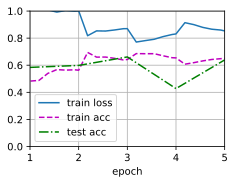

In [53]:
d2l.train_ch13(rnn_side_effects, train_iter, test_iter, loss, optimizer, num_epochs)

In [54]:
y_pred, y_true, confidence = predict(rnn_side_effects, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.638996138996139
balanced_accuracy: 0.4717270537770511
f_1: 0.44325427931985306
roc_auc: 0.7101466780671397
precision: 0.4661594104162035
recall: 0.4717270537770511


/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## GRU

In [55]:
embed_size, num_hiddens, num_layers = 100, 100, 2

gru_side_effects = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.GRU)
gru_side_effects.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
gru_side_effects.embedding.weight.data.copy_(embeds)
gru_side_effects.embedding.weight.requires_grad = False

In [56]:
lr, num_epochs = 0.01, 5
optimizer = Adam(gru_side_effects.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.489, train acc 0.805, test acc 0.688
19.4 examples/sec on [device(type='cpu')]


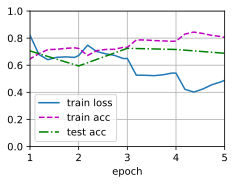

In [57]:
d2l.train_ch13(gru_side_effects, train_iter, test_iter, loss, optimizer, num_epochs)

In [58]:
y_pred, y_true, confidence = predict(gru_side_effects, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.6882239382239382
balanced_accuracy: 0.623061441210837
f_1: 0.6410687640902255
roc_auc: 0.8397191455621013
precision: 0.6712555073757006
recall: 0.623061441210837


## LSTM

In [59]:
embed_size, num_hiddens, num_layers = 100, 100, 2

lstm_side_effects = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, nn.LSTM)
lstm_side_effects.apply(init_weights)

embeds = glove_embedding[vocab.idx_to_token]
lstm_side_effects.embedding.weight.data.copy_(embeds)
lstm_side_effects.embedding.weight.requires_grad = False

In [60]:
lr, num_epochs = 0.01, 5
optimizer = Adam(lstm_side_effects.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.591, train acc 0.763, test acc 0.678
21.4 examples/sec on [device(type='cpu')]


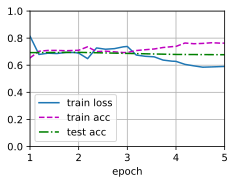

In [61]:
d2l.train_ch13(lstm_side_effects, train_iter, test_iter, loss, optimizer, num_epochs)

In [62]:
y_pred, y_true, confidence = predict(lstm_side_effects, test_iter)
metrics(y_pred, y_true, confidence)

/tmp/ipykernel_104123/1707141578.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence.append(softmax(pred).cpu().numpy())


accuracy: 0.6776061776061776
balanced_accuracy: 0.572419886363933
f_1: 0.5479304495559566
roc_auc: 0.8234720525051835
precision: 0.664642813002101
recall: 0.572419886363933
